Assumptions 

* Covid data reported is accurate
* What about home tests not reported?
* 7 day moving average of daily cases is a valid proxy for the current number of infected individuals  
* Recovery rate is static 
* ~~It is fair to use the total population minus the number of infected individuals to compute the number of   susceptible individuals 
* We will compute the susceptible population by taking the total population and subtracting the total number of individuals who have covid or had covid over the past 60 days
* Total population is static
* The probability of recovery (recovery rate) is defined by what percentage of infected individuals will recover by the next time period (next day). If a single person recovers in ~10 days, then the probability of recovery is 10%.
* 10% recovery rate is valid and accurate enough for our purposes.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.integrate import odeint

In [79]:
# from https://github.com/henrifroese/infectious_disease_modelling/blob/master/part_two.ipynb
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.ticklabel_format(useOffset=False, style='plain')
  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

In [2]:
df = pd.read_csv('us.csv', parse_dates=['date'])
df.drop(columns=['geoid'], inplace=True)

In [3]:
df = df[df.date > '2020-04-01']

In [4]:
df.head()

,date,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
72,2020-04-02,29717,22790.10,6.87,1216,737.69,0.22
73,2020-04-03,32318,24932.29,7.51,1391,879.29,0.26
74,2020-04-04,35099,26936.88,8.12,1556,1025.28,0.31
75,2020-04-05,25616,27951.16,8.42,1368,1162.74,0.35
76,2020-04-06,30916,29300.57,8.83,1526,1289.00,0.39


In [5]:
# constants
total_pop = 332403650
prob_recovery = .1

In [6]:
df['next_cases_avg'] = -(df.cases_avg.diff(periods=-1)) + df.cases_avg

In [7]:
df.head()

,date,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,next_cases_avg
72,2020-04-02,29717,22790.10,6.87,1216,737.69,0.22,24932.29
73,2020-04-03,32318,24932.29,7.51,1391,879.29,0.26,26936.88
74,2020-04-04,35099,26936.88,8.12,1556,1025.28,0.31,27951.16
75,2020-04-05,25616,27951.16,8.42,1368,1162.74,0.35,29300.57
76,2020-04-06,30916,29300.57,8.83,1526,1289.00,0.39,30136.30


In [8]:
# Let's define the susceptible population to exclude people who have had covid in the last 60 days
df['immune_period'] = df.cases.rolling(60).sum()

In [9]:
df['immune_period'] = df.apply(
    lambda x: x.cases if np.isnan(x.immune_period) else x.immune_period, axis=1
)

In [10]:
def get_prob_contact_spread(cases_avg, next_cases_avg, immune_period):
    inner = cases_avg / total_pop * (total_pop - immune_period)
    return next_cases_avg / inner + prob_recovery * cases_avg / inner - cases_avg / inner

In [11]:
df['prob_contact_spread'] = df.apply(
    lambda x: get_prob_contact_spread(x.cases_avg, x.next_cases_avg, x.immune_period), axis=1
)

In [12]:
df.head()

,date,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,next_cases_avg,immune_period,prob_contact_spread
72,2020-04-02,29717,22790.10,6.87,1216,737.69,0.22,24932.29,29717.0,0.194014
73,2020-04-03,32318,24932.29,7.51,1391,879.29,0.26,26936.88,32318.0,0.180419
74,2020-04-04,35099,26936.88,8.12,1556,1025.28,0.31,27951.16,35099.0,0.137668
75,2020-04-05,25616,27951.16,8.42,1368,1162.74,0.35,29300.57,25616.0,0.148289
76,2020-04-06,30916,29300.57,8.83,1526,1289.00,0.39,30136.30,30916.0,0.128535


In [13]:
df['r_zero'] = df.prob_contact_spread / prob_recovery

In [14]:
df['r_zero_ma'] = df.r_zero.rolling(7).mean()

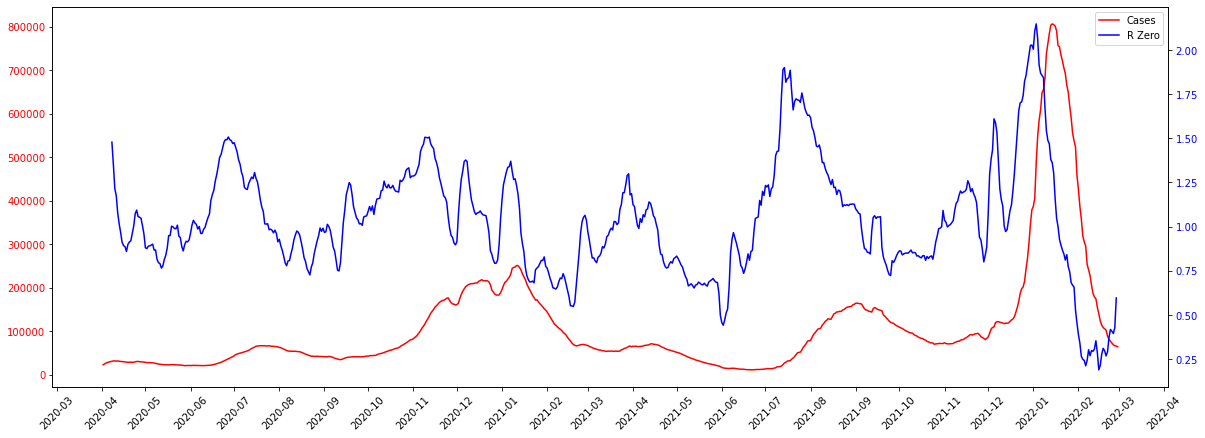

In [15]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(df.date, df.cases_avg, color='red', label='Cases')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='y', labelcolor='red')
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()

ax2.plot(df.date, df.r_zero_ma, color='blue', label='R Zero')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.show()

In [41]:
df.head()

,date,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,next_cases_avg,immune_period,prob_contact_spread,r_zero,r_zero_ma
72,2020-04-02,29717,22790.10,6.87,1216,737.69,0.22,24932.29,29717.0,0.194014,1.940139,NaN
73,2020-04-03,32318,24932.29,7.51,1391,879.29,0.26,26936.88,32318.0,0.180419,1.804189,NaN
74,2020-04-04,35099,26936.88,8.12,1556,1025.28,0.31,27951.16,35099.0,0.137668,1.376685,NaN
75,2020-04-05,25616,27951.16,8.42,1368,1162.74,0.35,29300.57,25616.0,0.148289,1.482889,NaN
76,2020-04-06,30916,29300.57,8.83,1526,1289.00,0.39,30136.30,30916.0,0.128535,1.285346,NaN


# Visualize the Susceptible, Exposed, Infected, Recovered

In [62]:
infections = df.cases_avg.tolist()
r_zero = df.r_zero.tolist()

In [63]:
def deriv(y, t, N, gamma, delta):
    t = int(t)
    S, E, R = y
    I = infections[t]
    RO = r_zero[t]
    beta = RO * gamma
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    # dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dRdt

In [67]:
N = total_pop
D = 10.0 # infections lasts ten days
gamma = 1.0 / D
delta = 1.0 / 3.0  # incubation period of three days
# R_0 = 5.0
# beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
S0, E0, R0 = N-1, 1, 0  # initial conditions: one exposed

In [68]:
t = np.arange(len(infections), dtype=np.int16)
y0 = S0, E0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, gamma, delta))
S, E, R = ret.T

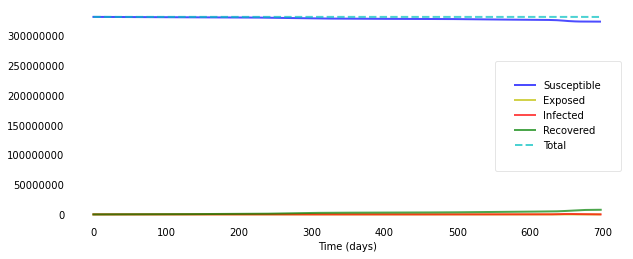

In [80]:
plotseird(t, S, E, infections, R)

# Visualizing Variant Data

In [16]:
variants = pd.read_csv('covid19_variants.csv')

In [17]:
variants.head()

,date,area,area_type,variant_name,specimens,percentage,specimens_7d_avg,percentage_7d_avg
0,2021-01-01,California,State,Beta,0.0,0.0,NaN,NaN
1,2021-01-01,California,State,Total,57.0,100.0,NaN,NaN
2,2021-01-01,California,State,Lambda,0.0,0.0,NaN,NaN
3,2021-01-01,California,State,Gamma,0.0,0.0,NaN,NaN
4,2021-01-01,California,State,Mu,0.0,0.0,NaN,NaN


In [18]:
grouped_variants = variants.groupby(['date', 'variant_name'])['percentage'].mean().reset_index()

In [19]:
grouped_variants.head()

,date,variant_name,percentage
0,2021-01-01,Alpha,1.75
1,2021-01-01,Beta,0.00
2,2021-01-01,Delta,0.00
3,2021-01-01,Epsilon,47.37
4,2021-01-01,Gamma,0.00


In [20]:
grouped_variants = grouped_variants[grouped_variants.variant_name != 'Total']

In [21]:
pivot = grouped_variants.pivot(index='date', columns='variant_name', values='percentage')

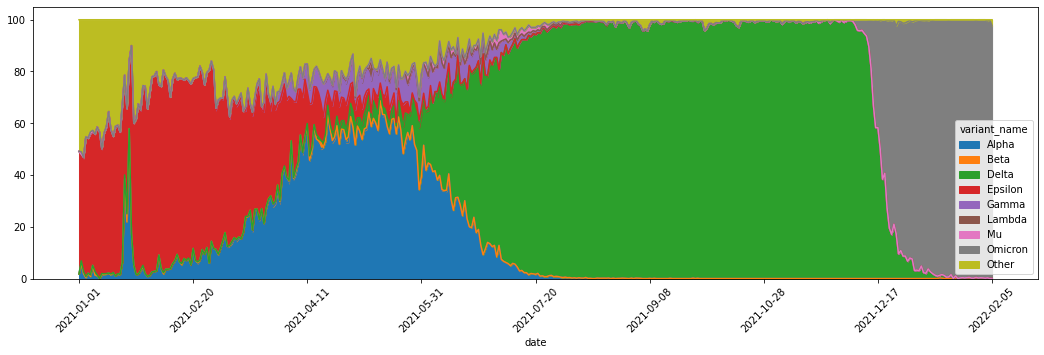

In [22]:
pivot.plot.area(figsize=(18,5), rot=45)

In [23]:
# Hypothesis: Covid variant has a significant impact on R Zero

In [24]:
# Create arbitrary score for variant
delta_score = 10
omicron_score = 20
all_others = 1

In [25]:
def apply_score(variant_name):
    if variant_name == 'Omicron':
        return omicron_score
    if variant_name == 'Delta':
        return delta_score
    return all_others

In [26]:
grouped_variants['score'] = grouped_variants.percentage / 100 * grouped_variants.variant_name.apply(apply_score)

In [27]:
grouped_variants

,date,variant_name,percentage,score
0,2021-01-01,Alpha,1.75,0.0175
1,2021-01-01,Beta,0.00,0.0000
2,2021-01-01,Delta,0.00,0.0000
3,2021-01-01,Epsilon,47.37,0.4737
4,2021-01-01,Gamma,0.00,0.0000
...,...,...,...,...
4004,2022-02-05,Gamma,0.00,0.0000
4005,2022-02-05,Lambda,0.00,0.0000
4006,2022-02-05,Mu,0.00,0.0000
4007,2022-02-05,Omicron,97.67,19.5340


In [28]:
daily_scores = grouped_variants.groupby('date')['score'].sum().reset_index()

In [29]:
daily_scores['date'] = pd.to_datetime(daily_scores.date)

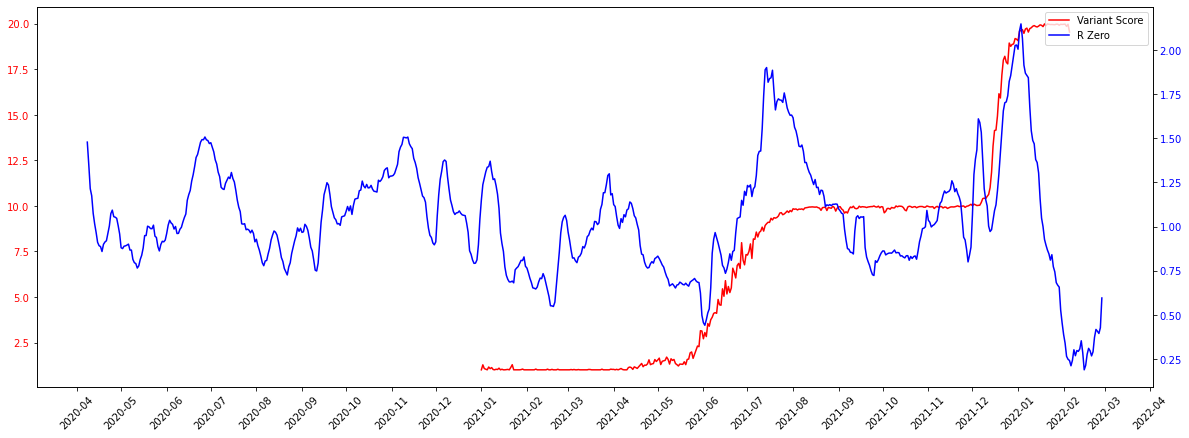

In [30]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(daily_scores.date, daily_scores.score, color='red', label='Variant Score')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='y', labelcolor='red')
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()

ax2.plot(df.date, df.r_zero_ma, color='blue', label='R Zero')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.show()

Explanation of the above chart:

The variant score is the result of an arbitrary number assigned to each variant, where omicron is a higher number than delta, and delta is a higher number than all other variants, then this number is applied to the variant dataset to show the prevalance/potency of certain variants or combinations of variants at a specific moment in time. The purpose of this score is to have something to correlate with the R zero visually to see if spikes in R zero correlate to the introduction of new variants, specifically delta and omicron.

In [ ]:
# Next: Look at vaccination data

In [ ]:
# Also next: look at https://colab.research.google.com/github/hf2000510/infectious_disease_modelling/blob/master/part_two.ipynb#scrollTo=8j_amELsSZ4n.
# Fit existing covid data to derive the number of exposed, infected, recovered, and susceptible individuals